<a href="https://colab.research.google.com/github/singhnidh/Plant-disease-detection-using-Deep-Learning-and-Machine-Vision/blob/main/1_FINAL_VGG16_TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

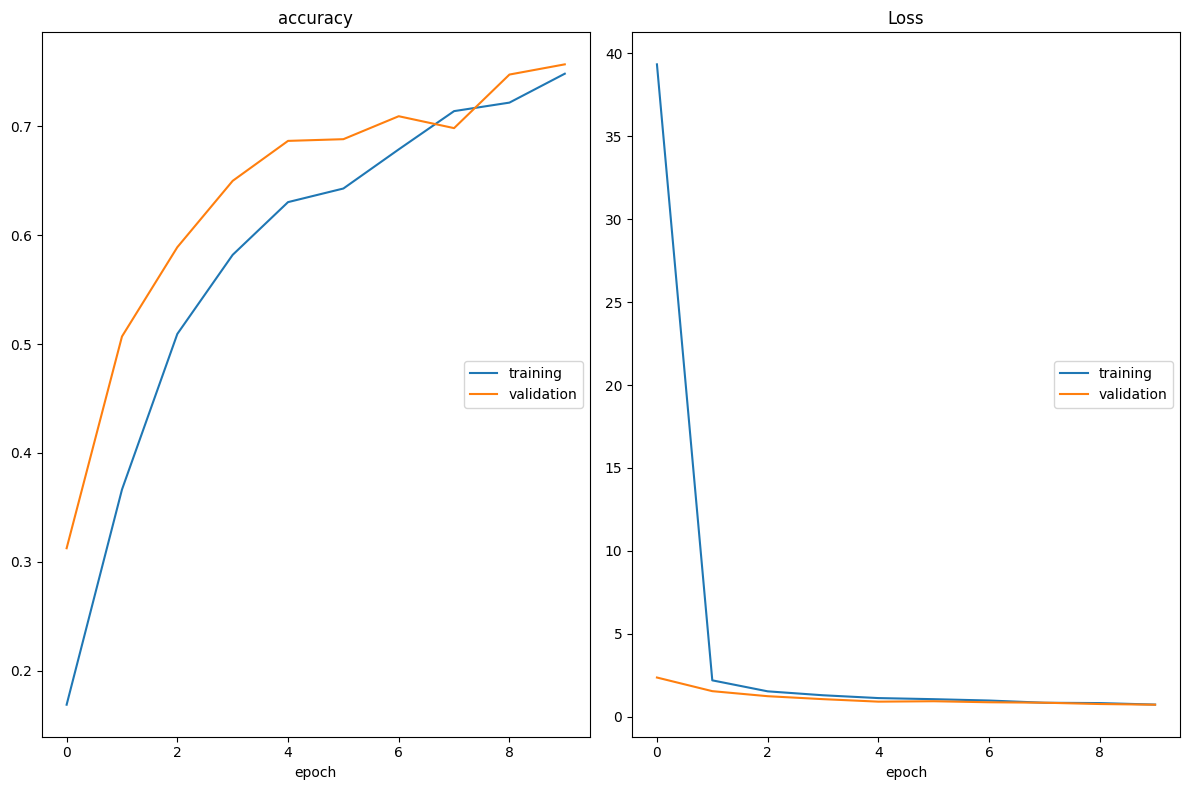

accuracy
	training         	 (min:    0.169, max:    0.748, cur:    0.748)
	validation       	 (min:    0.312, max:    0.757, cur:    0.757)
Loss
	training         	 (min:    0.739, max:   39.329, cur:    0.739)
	validation       	 (min:    0.732, max:    2.370, cur:    0.732)
20/20 [==============================] - 1094s 56s/step - loss: 0.7389 - accuracy: 0.7484 - val_loss: 0.7319 - val_accuracy: 0.7570


In [ ]:
import os
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np

BATCH_SIZE = 64

train_generator = ImageDataGenerator(rotation_range=90,
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5,
                                     height_shift_range=0.5,
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing

download_dir = Path('/content/drive/MyDrive/VIT PROJECT WORK/Mater Project VIT FINAL SEM/ DATASET/PlantVillage-Dataset')

train_data_dir = download_dir/' dataset_original'
test_data_dir = download_dir/' Augmented Dataset'

class_subset = os.listdir(download_dir/' dataset_original')
traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             class_mode=None,
                                             classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

#Using Pre-trained Layers for Feature Extraction

def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers

    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """

    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet',
                     input_shape=input_shape)

    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)

    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.summary()
    return model

#Training Without Fine-Tuning

input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=20

n_steps =20 # traingen.samples // BATCH_SIZE
n_val_steps =20 # validgen.samples // BATCH_SIZE
n_epochs = 10

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)


!pip install livelossplot

from livelossplot.inputs.keras import PlotLossesCallback
plot_loss_1 = PlotLossesCallback()
# Rest of your code...
# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)
# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')


#We can now train the model defined above:

vgg_history = vgg_model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)


#Saving our model
filepath="/content/drive/MyDrive/VIT PROJECT WORK/Mater Project VIT FINAL SEM/model notebook/vggnet16_t2_another.h5"
vgg_model.save(filepath)

In [ ]:
# Generate predictions
#vgg_model.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = vgg_model.predict(testgen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

10472/10472 [==============================] - 4367s 417ms/step


In [ ]:
from sklearn.metrics import accuracy_score

vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy without Fine-Tuning: {:.2f}%".format(vgg_acc * 100))

VGG16 Model Accuracy without Fine-Tuning: 72.04%


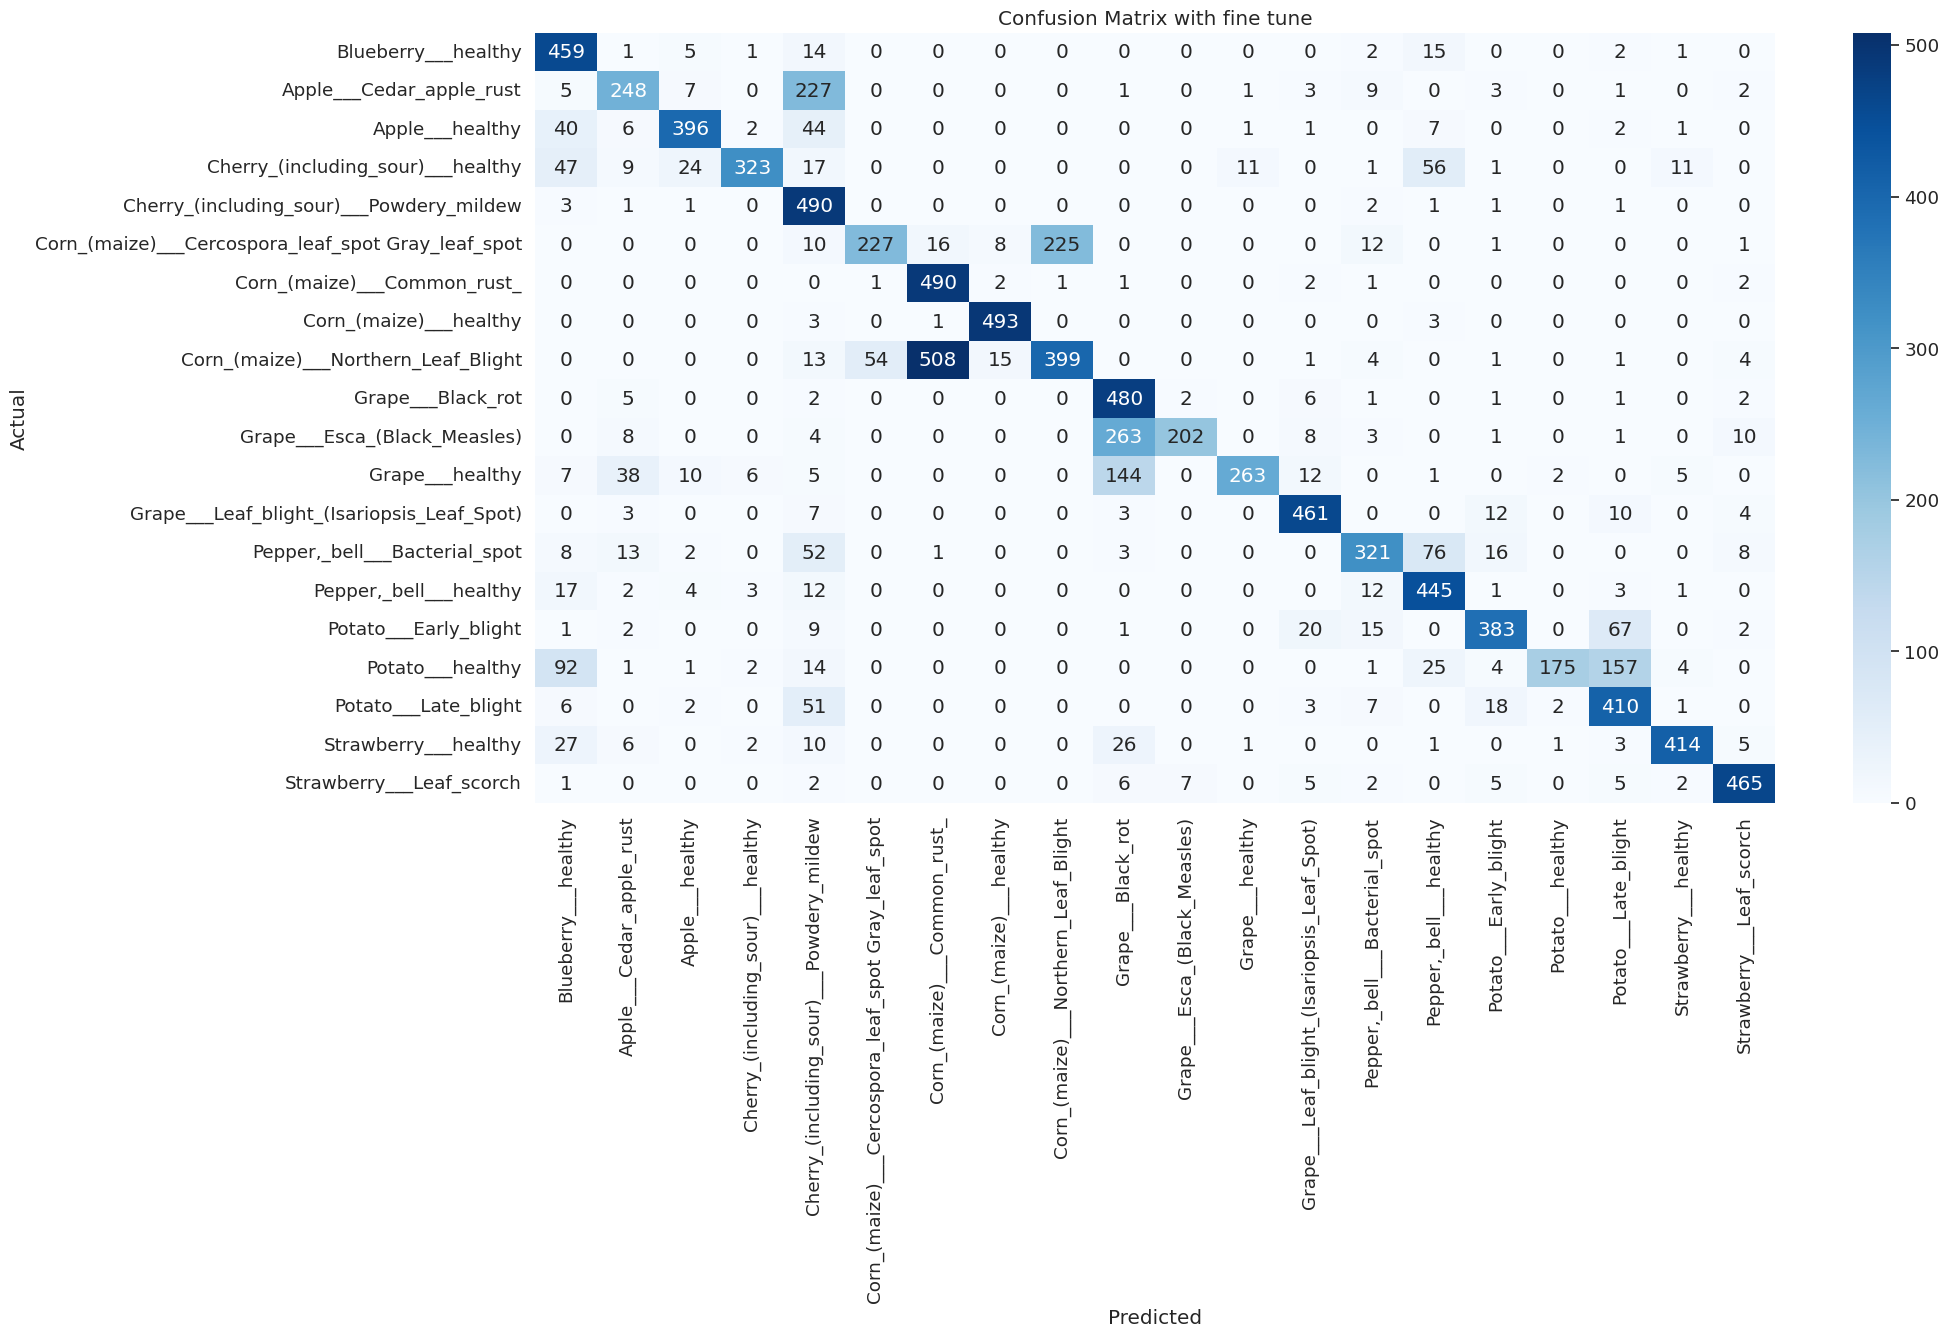

In [ ]:
# Confusion Matrix, Accuracy, F1 Score, Precision, Recall after fine-tuning
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Compute the confusion matrix
cm = confusion_matrix(true_classes, vgg_pred_classes)
# Define class names if you have them
class_names = testgen.class_indices.keys()


# Create a heatmap
plt.figure(figsize=(20,10))
sns.set(font_scale=1.2)  # Adjust the font size as needed
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with fine tune')
plt.show()


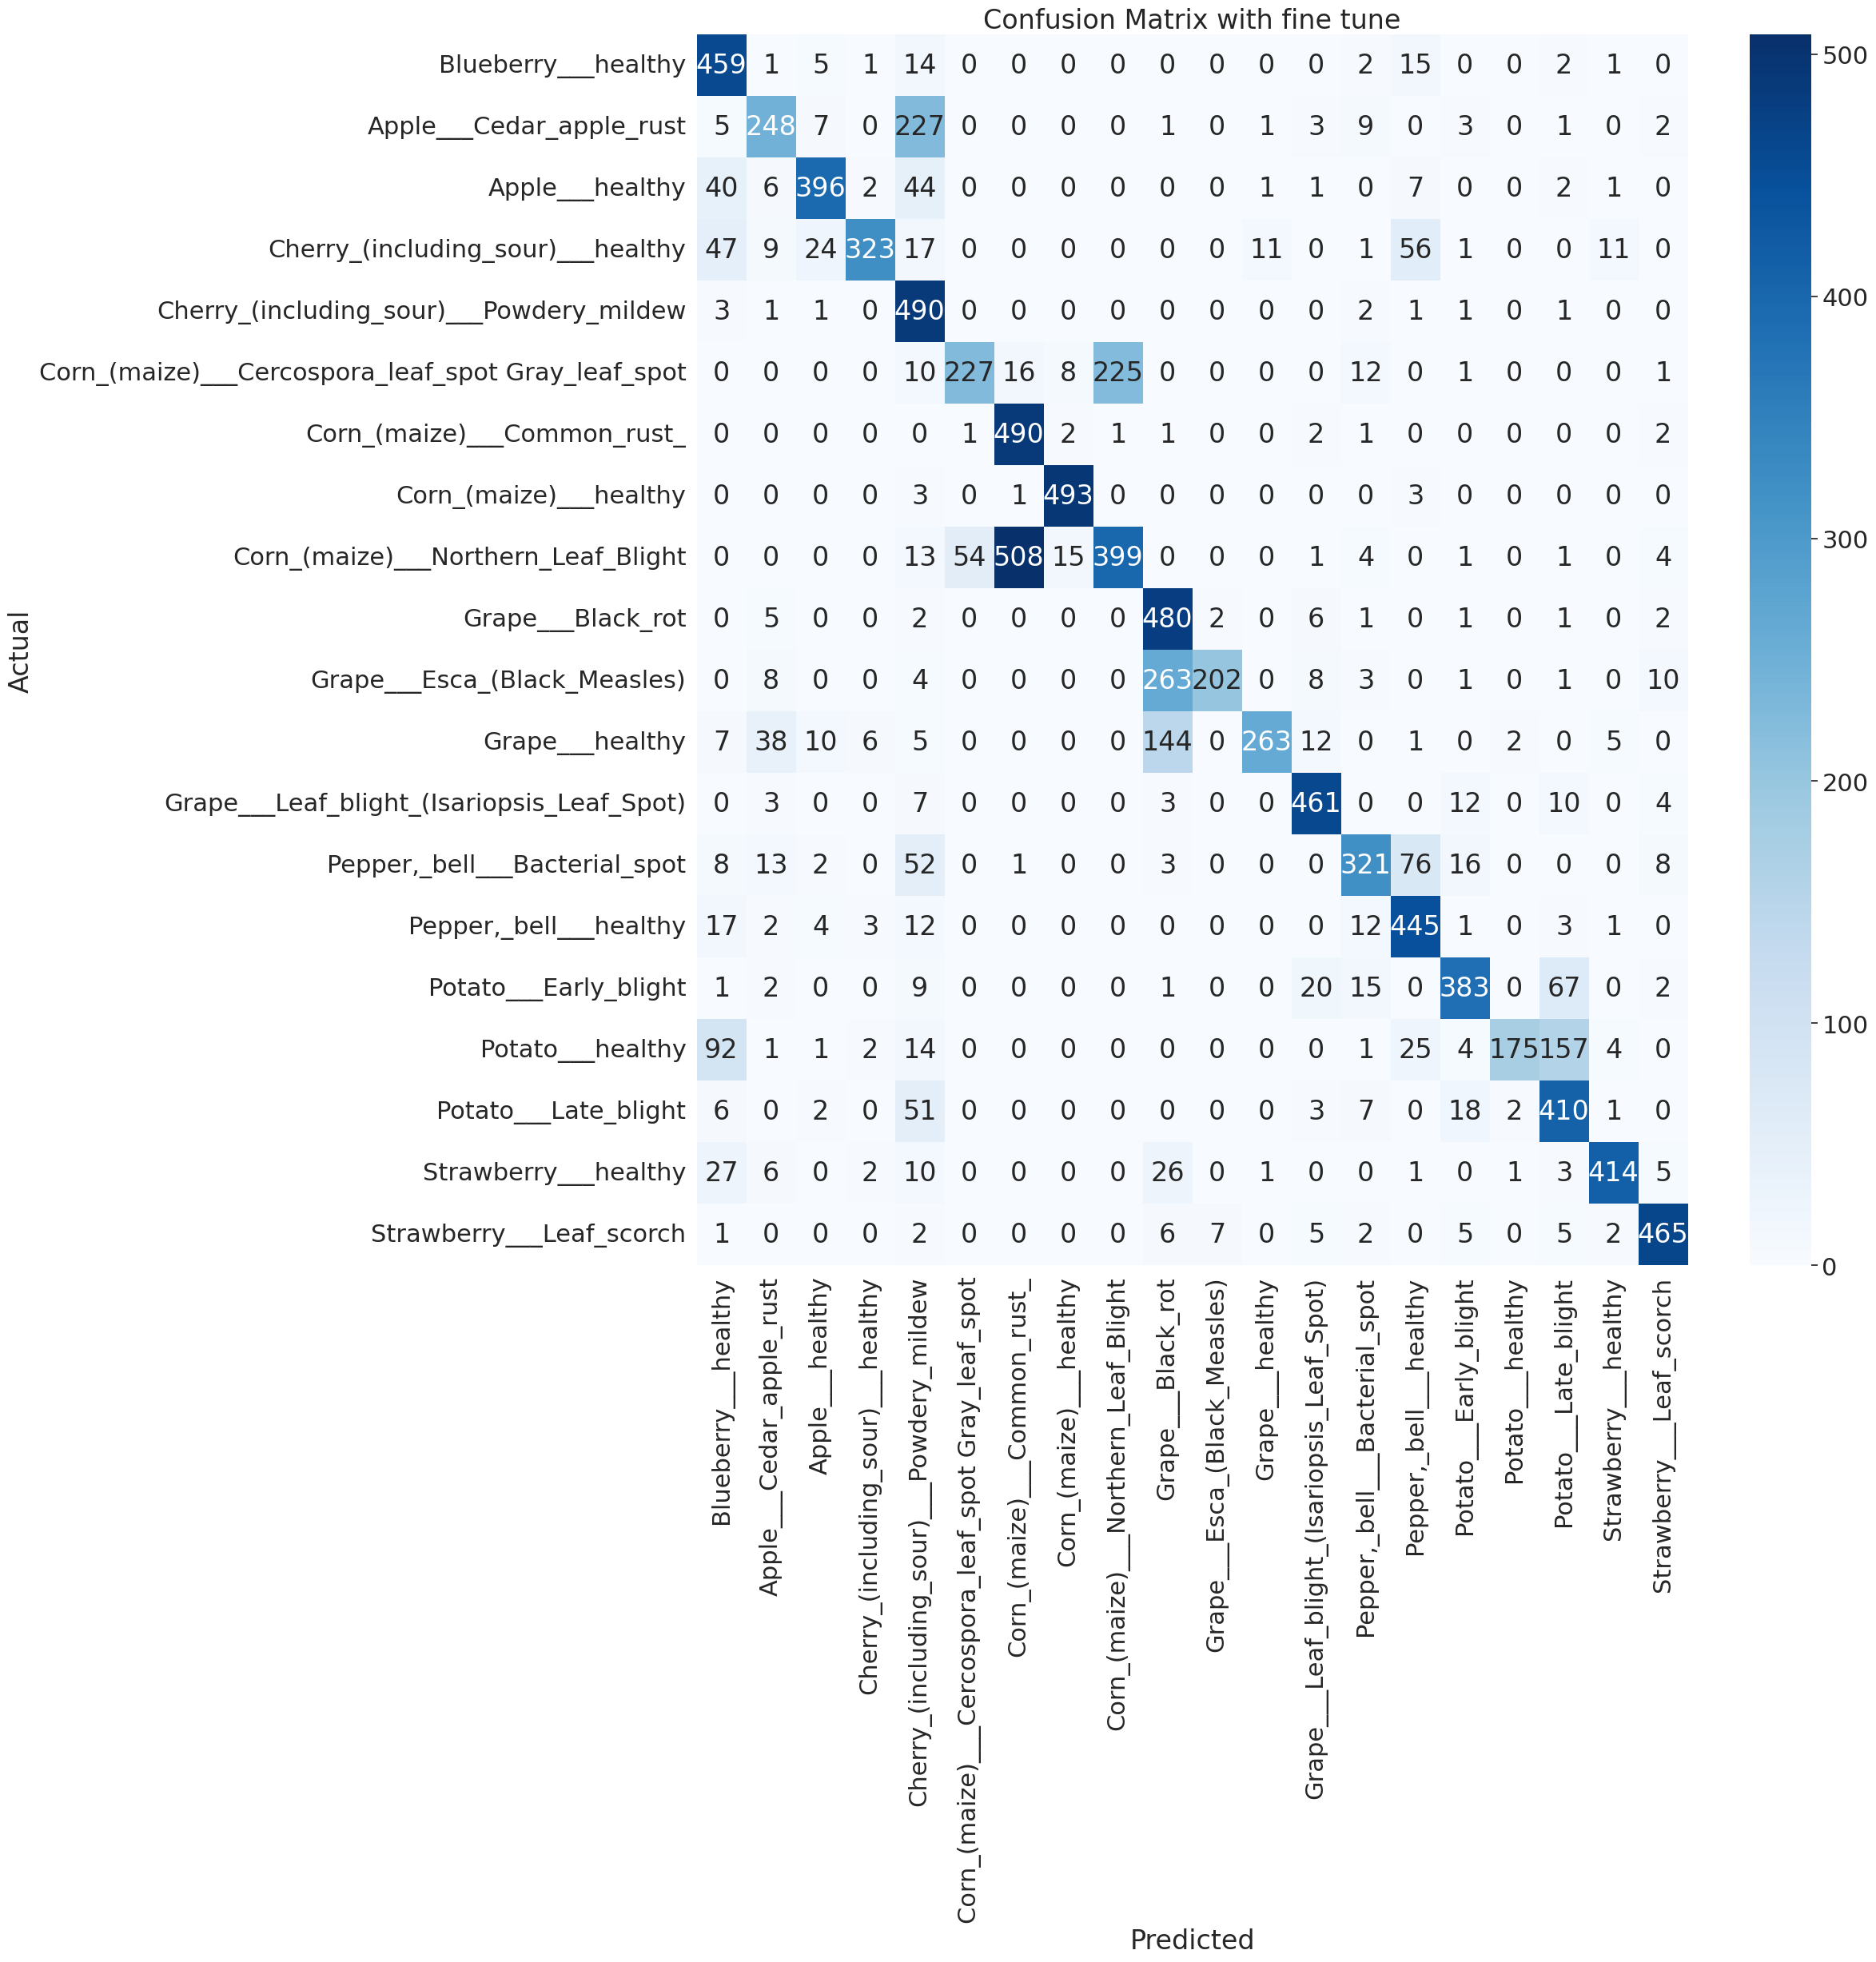

In [ ]:
# Confusion Matrix, Accuracy, F1 Score, Precision, Recall after fine-tuning
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Compute the confusion matrix
cm = confusion_matrix(true_classes, vgg_pred_classes)
# Define class names if you have them
class_names = testgen.class_indices.keys()


# Create a heatmap
plt.figure(figsize=(20,20))
sns.set(font_scale=2)  # Adjust the font size as needed
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with fine tune')
plt.show()


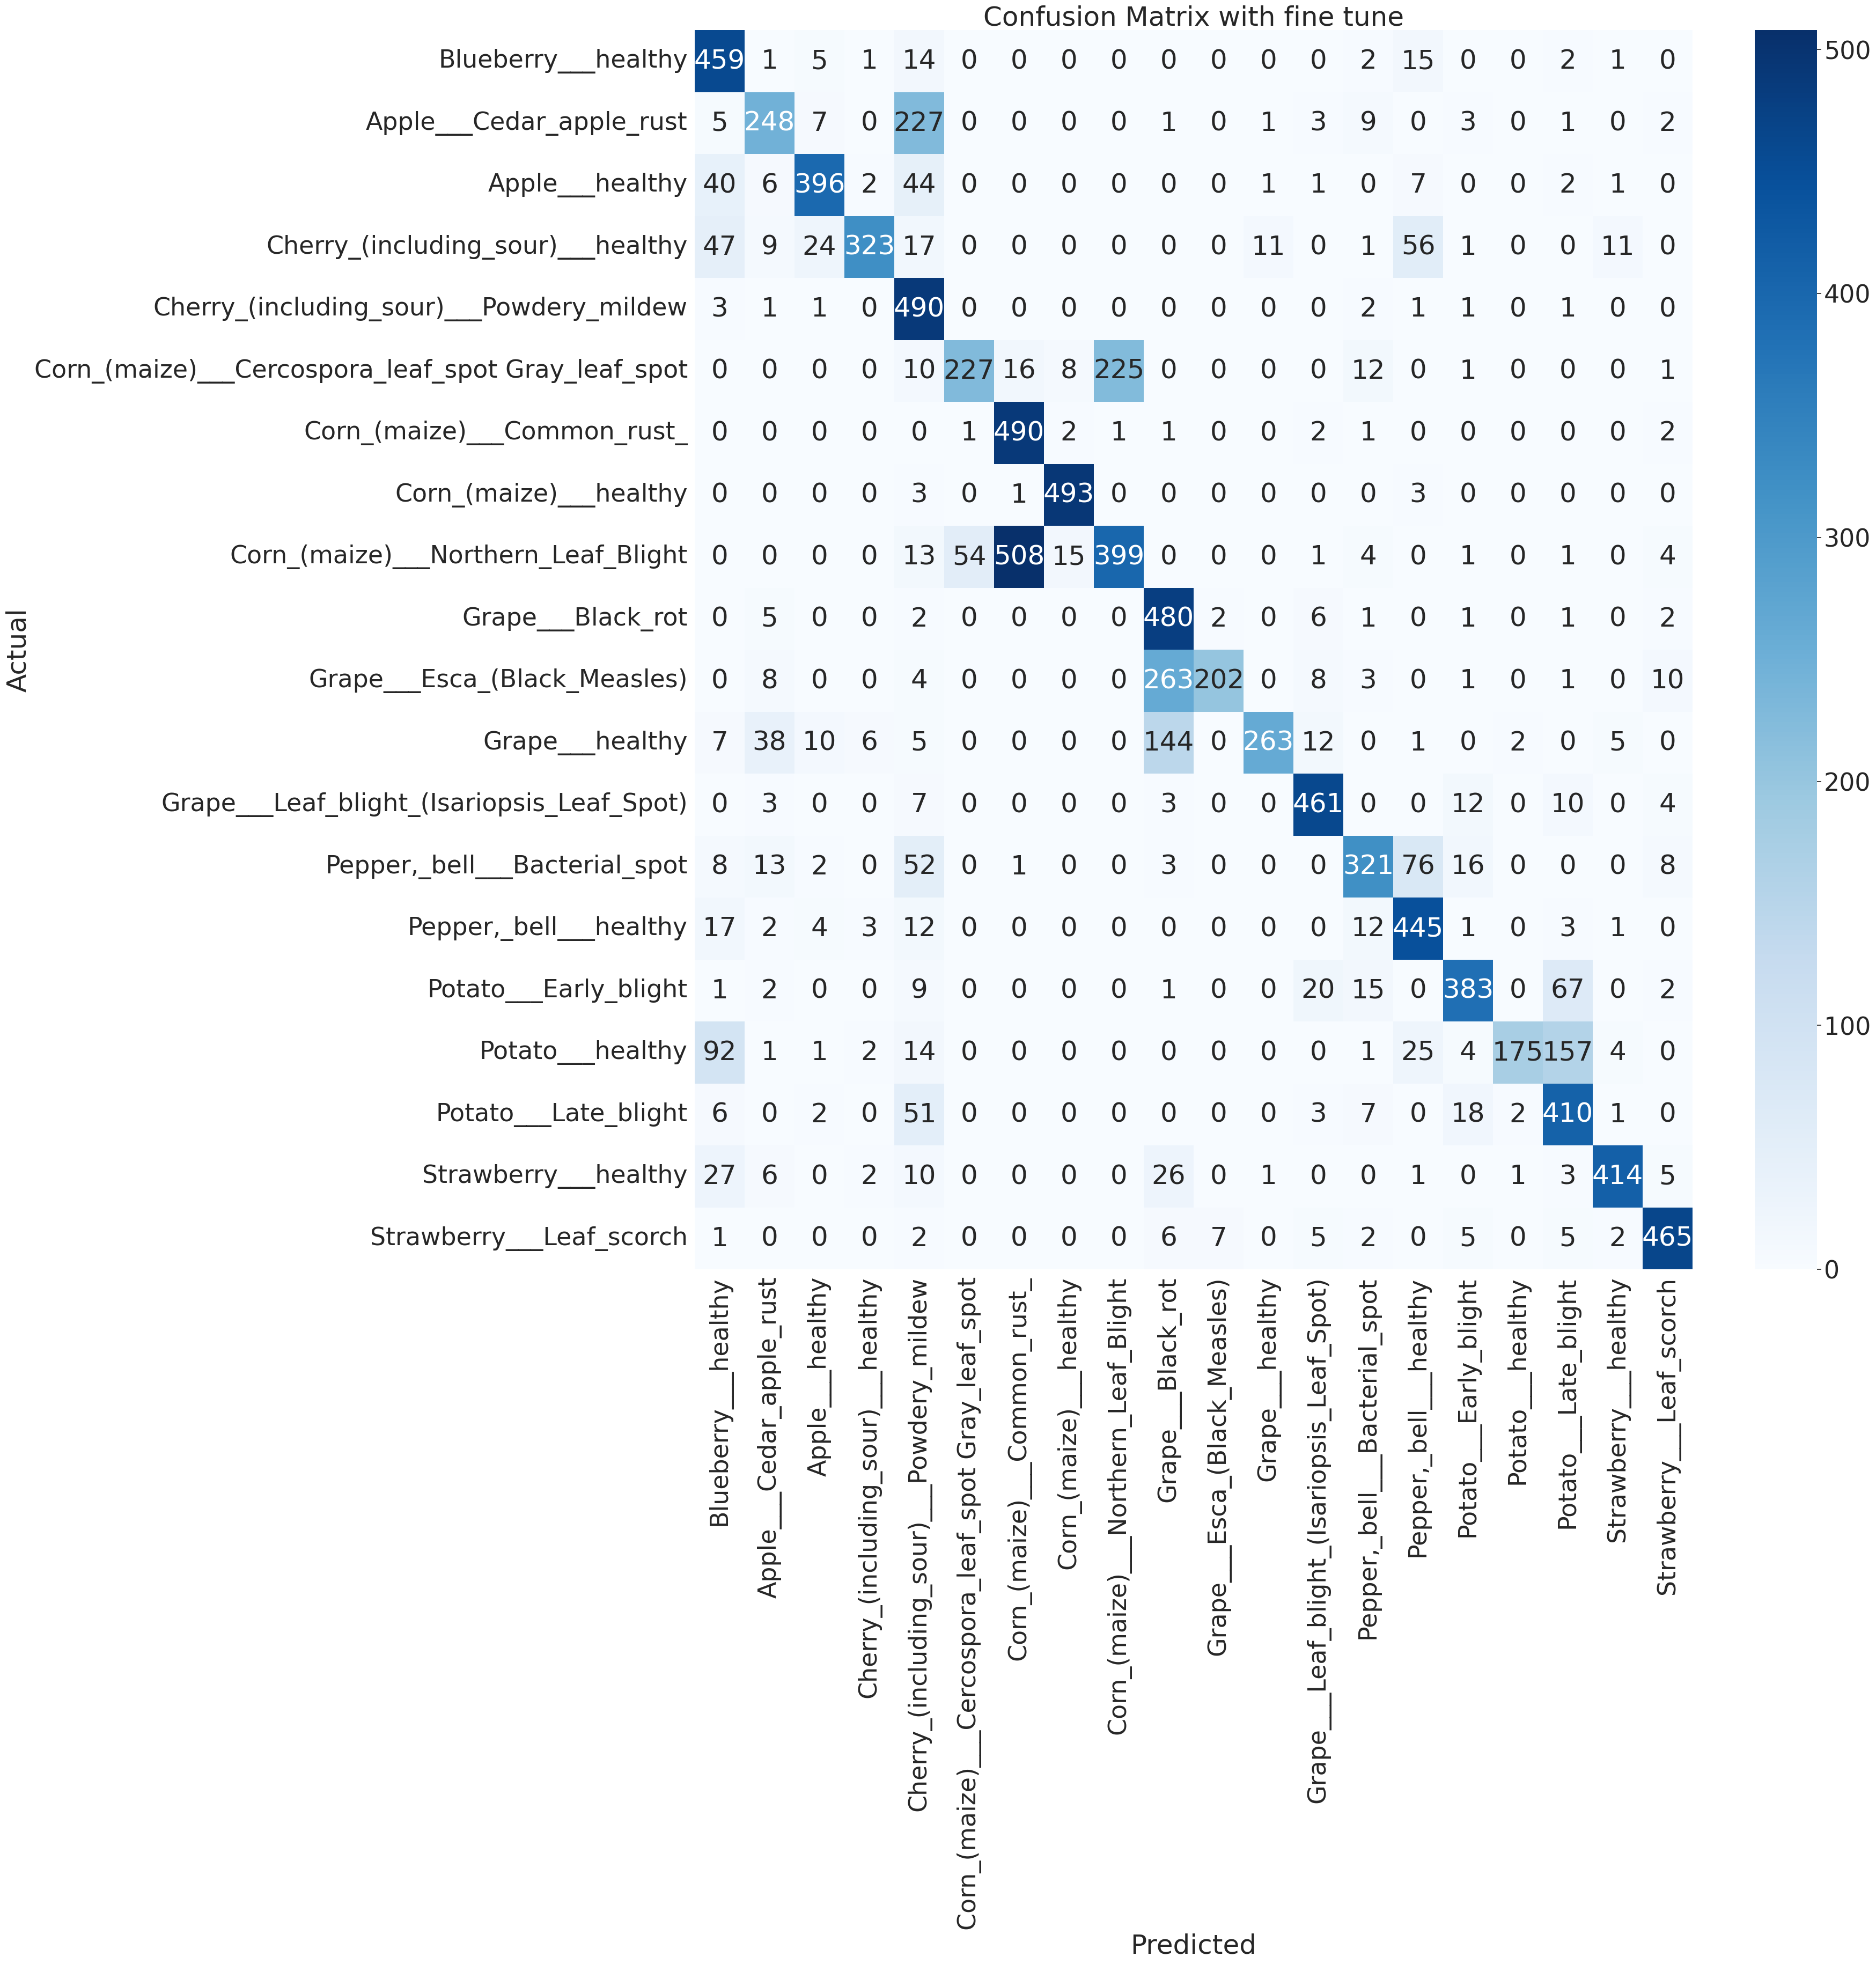

In [ ]:
# Confusion Matrix, Accuracy, F1 Score, Precision, Recall after fine-tuning
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

# Compute the confusion matrix
cm = confusion_matrix(true_classes, vgg_pred_classes)
# Define class names if you have them
class_names = testgen.class_indices.keys()


# Create a heatmap
plt.figure(figsize=(30,30))
sns.set(font_scale=3)  # Adjust the font size as needed
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix with fine tune')
plt.show()


In [ ]:
# Predict on the validation set
#y_pred = vgg_model_ft.predict(testgen)
y_pred = vgg_preds
y_true = testgen.classes
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate metrics
cm = confusion_matrix(y_true, y_pred_classes)
classification_rep = classification_report(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Display the confusion matrix
print("Confusion Matrix:")
print(cm)

# Display classification report, precision, recall, and F1 score
print("\nClassification Report:")
print(classification_rep)
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")


Confusion Matrix:
[[459   1   5   1  14   0   0   0   0   0   0   0   0   2  15   0   0   2
    1   0]
 [  5 248   7   0 227   0   0   0   0   1   0   1   3   9   0   3   0   1
    0   2]
 [ 40   6 396   2  44   0   0   0   0   0   0   1   1   0   7   0   0   2
    1   0]
 [ 47   9  24 323  17   0   0   0   0   0   0  11   0   1  56   1   0   0
   11   0]
 [  3   1   1   0 490   0   0   0   0   0   0   0   0   2   1   1   0   1
    0   0]
 [  0   0   0   0  10 227  16   8 225   0   0   0   0  12   0   1   0   0
    0   1]
 [  0   0   0   0   0   1 490   2   1   1   0   0   2   1   0   0   0   0
    0   2]
 [  0   0   0   0   3   0   1 493   0   0   0   0   0   0   3   0   0   0
    0   0]
 [  0   0   0   0  13  54 508  15 399   0   0   0   1   4   0   1   0   1
    0   4]
 [  0   5   0   0   2   0   0   0   0 480   2   0   6   1   0   1   0   1
    0   2]
 [  0   8   0   0   4   0   0   0   0 263 202   0   8   3   0   1   0   1
    0  10]
 [  7  38  10   6   5   0   0   0   0 144   0 2

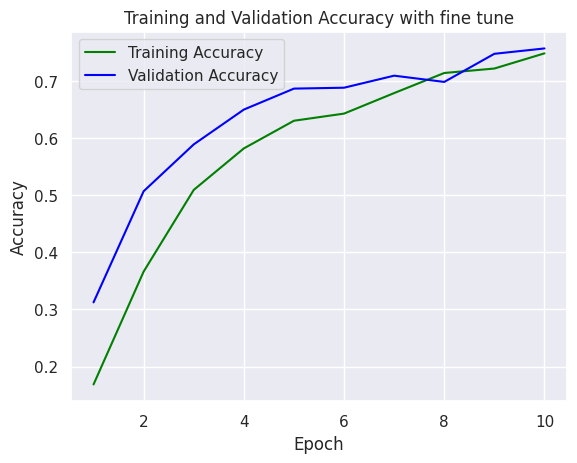

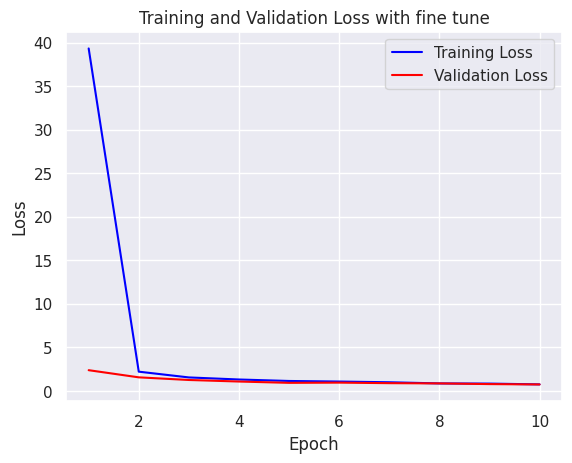

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

acc = vgg_history.history['accuracy']
val_acc = vgg_history.history['val_accuracy']
loss = vgg_history.history['loss']
val_loss = vgg_history.history['val_loss']
epochs = range(1, len(loss) + 1)

#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy with fine tune')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(epochs, loss, color='blue', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss with fine tune')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


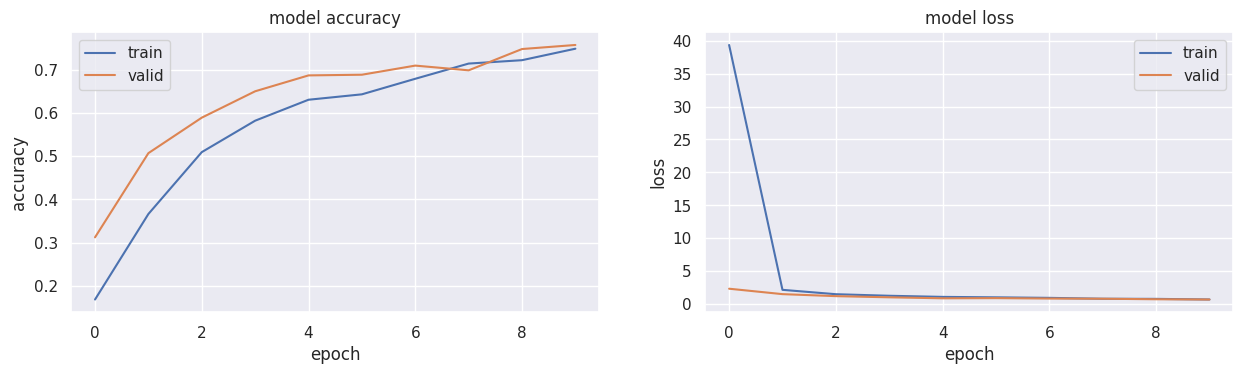

In [ ]:
# Confusion Matrix, Accuracy, F1 Score, Precision, Recall after fine-tuning
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

plt.figure(1, figsize = (15,8))

plt.subplot(221)
plt.plot(vgg_history.history['accuracy'])
plt.plot(vgg_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])

plt.subplot(222)
plt.plot(vgg_history.history['loss'])
plt.plot(vgg_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'])

plt.show()

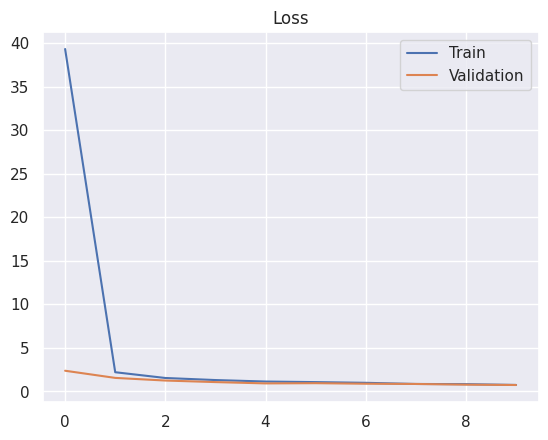

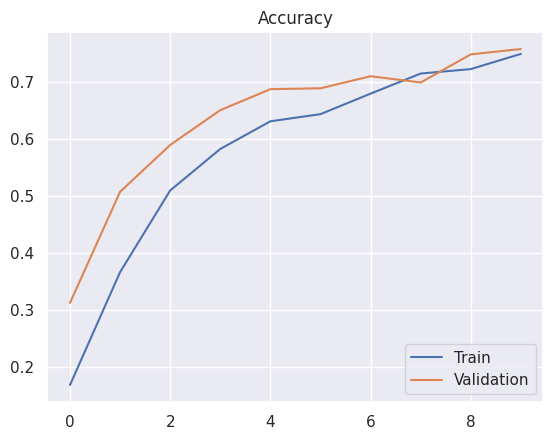

In [ ]:

loss_train_curve = vgg_history.history["loss"]
loss_val_curve = vgg_history.history["val_loss"]
plt.plot(loss_train_curve, label = "Train")
plt.plot(loss_val_curve, label = "Validation")
plt.legend(loc = 'upper right')
plt.title("Loss")
plt.show()
acc_train_curve = vgg_history.history["accuracy"]
acc_val_curve = vgg_history.history["val_accuracy"]
plt.plot(acc_train_curve, label = "Train")
plt.plot(acc_val_curve, label = "Validation")
plt.legend(loc = 'lower right')
plt.title("Accuracy")
plt.show()

In [ ]:
print(vgg_history)

1/1 [==============================] - 1s 820ms/step


Text(0.5, 1.0, 'predicted: 0')

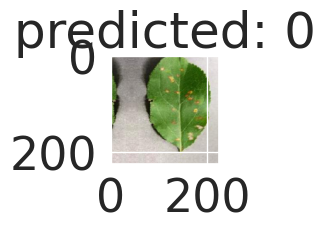

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
font_scale=1.5
# Load an image from file
img_path = '/content/drive/MyDrive/VIT PROJECT WORK/Mater Project VIT FINAL SEM/ DATASET/PlantVillage-Dataset/ Augmented Dataset/Apple___Cedar_apple_rust/aug_0_3915.jpg'
img = image.load_img(img_path, target_size=(224, 224))

# Convert the image to a numpy array
img_array = image.img_to_array(img)

# Add an extra dimension and preprocess the image
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)
i=1
# Make the prediction
predictions = vgg_model.predict(img_array)
#print(predictions)
predicted = vgg_pred_classes[np.argmax(predictions)]
plt.subplot(240+1+i)
plt.imshow(img)
plt.title('predicted: ' + str(predicted))
# Decode and print the top-3 predicted classes
#decoded_predictions = decode_predictions(predictions, top=3)
#print(decoded_predictions)
